Here we want to start testing out how to use ML methods to identify the true CBs, inspired by the DropEst BioRxiv manuscript. We can get most of the information we require from the 10X BAM file, namely:

We are going to use
1. Fraction of non-genic reads (Since this is what we will be able to obatin in alevin)
2. Fraction of Mt reads (This was used in DropEst as a hard threshold. We want to see whether it's useful to include in ML)
3. Duplication rate
4. Some measure(s) of expression distribution
5. Mean CB quality
6. Max correlation with true cells


Note that this is quite different to the DropEst metrics:
1. Mean # reads per UMI
2. Mean # UMIs per gene
3. Fraction low-expressed genes (1 read per gene)
4. Fraction of UMIs on low-expressed genes
5. Fraction of Integenic reads
6. Fraction of non-aligned reads



In [2]:
import pyximport
pyximport.install(reload_support=True)
from umi_tools._dedup_umi import edit_distance
import umi_tools.umi_methods as umi_methods
import umi_tools.Utilities as U
import collections
import pandas as pd
import numpy as np
import scipy
import pysam
import regex
from datetime import datetime
%load_ext rpy2.ipython
%matplotlib inline  

In [3]:
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB


BAM infile:
* All reads (no CBs filtered out)
* CB and UMI extracted
* Aligned to combined human and mouse genomes (contig names prefixed with "hg" and "mm", respectively)
* Genes assigned (featureCounts)

In [4]:
bam_infile = "/home/FILESERVER5/proteomics/tss38/ifs/projects/toms/cell_barcode/run/mapped/hgmm_1k_extracted.bam.featureCounts.bam"

In [5]:
def getCounterMeanPhred(counter):
    '''
    Return the mean error rate from a counter of error rates on a Phred scale
    
    To get the mean error rate, need to convert Phred back into an actual probability
    '''
    
    sum_prob = 0
    total_count = 0
    for number, count in counter.most_common():
        prob = 10**(number/(-10))
        sum_prob += (prob*count)
        total_count += count
    mean = sum_prob/total_count
    
    return mean 

Here we parse the input BAM and tally read events, e.g reads per CB

In [7]:
def phredToInt(phreds):
    return(list(map(lambda x: ord(x)-33, phreds)))

qualities = collections.defaultdict(collections.Counter)

genome2reads = collections.Counter()
cell_umi_counts = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.Counter()))
cell_counts = collections.Counter()
cell_gene_counts = collections.defaultdict(lambda: collections.Counter())
cell2species = collections.defaultdict(collections.Counter)
inbam = pysam.Samfile(bam_infile)
cell_counts_mapped = collections.defaultdict(collections.Counter)
contigs = set()

n = 0
for read in inbam.fetch(until_eof=True):
    
    umi, cell = [x.decode() for x in umi_methods.get_barcode_read_id(read, cell_barcode=True)]
    
    if read.is_secondary:
        continue
    
    if read.is_unmapped:
        cell_counts_mapped[cell]['unmapped'] += 1
    else:
        cell_counts_mapped[cell]['mapped'] += 1
        
        species = read.reference_name.split("_")[0]
        contig = "_".join(read.reference_name.split("_")[1:])
        contigs.add(contig)
        genome2reads[species] += 1
        
        if contig.startswith("chrM"):
            cell_counts_mapped[cell]['Mt'] += 1
        try:
            gene = read.get_tag("XT")
            cell_gene_counts[cell][gene] +=1
            cell_umi_counts[cell][gene][umi] += 1
        except KeyError:
            pass # no gene assigned

        cell2species[cell][species] += 1
    
    cell_counts[cell] += 1
    qualities[cell].update(read.query_qualities)
    
    n+=1
    
    if n % 10000000 == 0:
        print("processed %iM reads %s" % (
            (float(n)/1000000), datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
    
print("processed %i reads %s" % (
    n, datetime.now().strftime('%Y-%m-%d %H:%M:%S')))


    




processed 10M reads 2017-10-09 08:58:52
processed 20M reads 2017-10-09 09:03:24
processed 30M reads 2017-10-09 09:08:01
processed 40M reads 2017-10-09 09:12:24
processed 50M reads 2017-10-09 09:16:56
processed 60M reads 2017-10-09 09:21:31
processed 63252296 reads 2017-10-09 09:23:04


Now we convert the tallies into the various metrics we want to use to train the ML methods. Note, some of the metrics collected are not used, e.g "genes". These metrics are instead collected for visualisation purposes later

In [9]:
rows = []
n = 0
for cell in cell_counts:
    reads = cell_counts[cell]
    
    if reads < 100:
        continue
    
    mapped = cell_counts_mapped[cell]['mapped']

    if mapped == 0:
        continue

    unmapped = cell_counts_mapped[cell]['unmapped']
    assigned = sum(list(cell_gene_counts[cell].values()))
    mt_reads = cell_counts_mapped[cell]['Mt']
    genes = len(cell_gene_counts[cell])
    dedup_reads = sum([len(x) for x in cell_umi_counts[cell].values()])
    
    if assigned > 0:
        mean_reads_per_umi = np.mean([cell_umi_counts[cell][gene][umi] for gene in cell_umi_counts[cell]
             for umi in cell_umi_counts[cell][gene]])
    
        ratio_mean_max = mean_reads_per_umi/max(
            [cell_umi_counts[cell][gene][umi] for gene in cell_umi_counts[cell]
                 for umi in cell_umi_counts[cell][gene]])
        assigned_fraction = assigned/mapped
    
    else:
        mean_reads_per_umi = 0
        ratio_mean_max = 0
        assigned_fraction = 0

    aligned_fraction = mapped/reads
    
    mt_fraction = mt_reads/mapped
    duplication_rate = 1-(dedup_reads/mapped)

    mean_qual = getCounterMeanPhred(qualities[cell])
    
    hg_reads = cell2species[cell]["hg"]
    mm_reads = cell2species[cell]["mm"]
    specificity = max((hg_reads, mm_reads))/(hg_reads + mm_reads)

    exp_counts = list(cell_gene_counts[cell].values())

    if len(exp_counts) > 0:
        mean_exp = np.mean(exp_counts)
        try:
            over_mean_exp = len([x for x in list(cell_gene_counts[cell].values()) if x > mean_exp])/genes
        except:
            print(genes)
            print(mean_exp)
            print(mean_exp == np.nan)
            raise ValueError()
    else:
        mean_exp = 0
        over_mean_exp = 0
    
    rows.append((cell, reads, aligned_fraction, assigned_fraction, mt_fraction,
                 duplication_rate, mean_reads_per_umi, ratio_mean_max, mean_qual,
                 over_mean_exp, mean_exp, genes, specificity))

In [10]:
def checkError(barcode, whitelist):
    ''' compare a barcode against a whitelist to see if it may be an error'''
    near_matches = set()
    comp_regex = regex.compile("(%s){e<=1}" % barcode)
    comp_regex2 = regex.compile("(%s){e<=1}" % barcode[:-1])
    b_length = len(barcode)
    for whitelisted_barcode in whitelist:
        w_length = len(whitelisted_barcode)
        if barcode == whitelisted_barcode:
            continue
        if (max(b_length, w_length) > (min(b_length, w_length) + 1)):
            continue
        if comp_regex.match(whitelisted_barcode) or comp_regex2.match(whitelisted_barcode):
            near_matches.add(whitelisted_barcode)
            if len(near_matches) > 1:
                return near_matches

    return near_matches

Below we:

1. Convert into a dataframe
2. standardise the metrics to [0-1]
3. group CBs into:
    * "true_cell" = the top 500 CBs
    * "pos_true_cell" & "pos_true_cell2" = the next 1000 CBs split into two 500 CB groups
    * "false_cell" = the rest

We'll use the "true_cell" and "false_cell" to train the model and then classify the 1000 CBs between true and false

In [11]:
df = pd.DataFrame.from_records(rows, columns=[
    "cell", "reads", "aligned", "assigned", "mt", "dup_rate", "mean_reads_umi",
    "ratio_mean_max", "mean_qual", "over_mean_exp", "mean_exp", "genes", "specificity"])

df.set_index("cell", inplace=True)

print(df.head())

for col in ["aligned", "assigned", "mt", "dup_rate", "mean_reads_umi",
            "ratio_mean_max", "mean_qual", "over_mean_exp", "mean_exp", "genes"]:
    max_col = max(df[col])
    min_col = min(df[col])
    df[col] = (df[col]-min_col)/(max_col-min_col)


sorted_df = df.sort_values("reads", ascending=False)
true_cells = sorted_df.ix[0:500].index
pos_true_cells = sorted_df.ix[500:1000].index
pos_true_cells2 = sorted_df.ix[1000:1500].index

cell_type = []
for x in df.index:
    if x in true_cells:
        cell_type.append("true_cell")
    elif x in pos_true_cells:
        cell_type.append("pos_true_cell")
    elif x in pos_true_cells2:
        cell_type.append("pos_true_cell2")
    else:
        cell_type.append("false cell")

#df['top_cell'] = [x in top_100_cells for x in df.index]
df['cell_type'] = cell_type

df['error'] = [len(checkError(x, true_cells))>0 for x in df.index]      

print(df.head())

                  reads   aligned  assigned        mt  dup_rate  \
cell                                                              
GTACTTTTCGTACCGG  24588  0.805840  0.650601  0.033663  0.502019   
CCGGATAGGCAATTAT    225  0.755556  0.752941  0.035294  0.411765   
CGGCTAGAGAATAGGG    107  0.766355  0.914634  0.073171  0.329268   
GGTGCGTAGCTGAACG    304  0.782895  0.815126  0.029412  0.336134   
GCTTGAAAGCGTAATA    127  0.771654  0.775510  0.000000  0.377551   

                  mean_reads_umi  ratio_mean_max  mean_qual  over_mean_exp  \
cell                                                                         
GTACTTTTCGTACCGG        1.306476        0.261295   0.004537       0.170940   
CCGGATAGGCAATTAT        1.280000        0.320000   0.003924       0.301075   
CGGCTAGAGAATAGGG        1.363636        0.340909   0.005495       0.340000   
GGTGCGTAGCTGAACG        1.227848        0.306962   0.005588       0.308824   
GCTTGAAAGCGTAATA        1.245902        0.311475   0.005840   

Next we derive the spearman's correlation between each cell and the true cells. We'll pre-compute ranks to save run-time

In [13]:
all_genes = set()
for cell in cell_counts.keys():
    genes = set(cell_umi_counts[cell].keys())
    all_genes.update(genes)
print(len(all_genes))

28368


In [14]:
true_cell_arrays = {}
for cell in true_cells:
    gene_exp_array = scipy.stats.rankdata([len(cell_umi_counts[cell][x]) for x in all_genes])
    true_cell_arrays[cell] = gene_exp_array
    
average_cell_array = []
for gene in all_genes:
    average_cell_array.append(np.mean([len(cell_umi_counts[cell][gene]) for cell in true_cells]))

average_cell_array = scipy.stats.rankdata(average_cell_array)


Now we need to calculate the max correlation for each cell relative to the true cells. let's see which approach is fastest for this

In [34]:
test_cell = df[df['cell_type']=="pos_true_cell"].index.tolist()[0]
cell_exp_array = scipy.stats.rankdata([len(cell_umi_counts[test_cell][x]) for x in all_genes])


In [35]:
%%timeit
max_cor = -1
for true_cell in true_cells:
    cor = scipy.stats.pearsonr(cell_exp_array, true_cell_arrays[true_cell])[0]
    if cor > max_cor:
        max_cor = cor


65.8 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
# required for pandas-based correlations
cell_exp_series = pd.Series(cell_exp_array)
ranks_df = pd.DataFrame.from_records(true_cell_arrays)

In [37]:
%%timeit
max_cor2 = max(ranks_df.apply(lambda x: x.corr(cell_exp_series)))

153 ms ± 3.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
%%timeit
max_cor3 = max(ranks_df.corrwith(cell_exp_series))

152 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
max_cor = -1
for true_cell in true_cells:
    cor = scipy.stats.pearsonr(cell_exp_array, true_cell_arrays[true_cell])[0]
    if cor > max_cor:
        max_cor = cor
        
cell_exp_series = pd.Series(cell_exp_array)
max_cor2 = max(ranks_df.apply(lambda x: x.corr(cell_exp_series)))

max_cor3 = max(ranks_df.corrwith(cell_exp_series))

print(max_cor)
print(max_cor2)
print(max_cor3)

0.57268142447
0.57268142447
0.57268142447


OK, so all approaches give the same answer (phew!). It appears the for loop is the fastest (unexpected) but this still takes ~65 ms for just 1 cell! 

In [41]:
n = 0
cor_with_true = [] # best correlation
ninth_dec_cor_with_true = [] # 90 percentile best correlation

cor_with_average = []
for cell in df.index:
    cell_exp_array = []
    # check for gene first rather than simply calling cell_umi_counts[cell][gene], otherwise 
    # cell_umi_counts becomes MASSIVELY inflated with zero counts!!
    for gene in all_genes: 
        if gene in cell_umi_counts[cell]:
            cell_exp_array.append(len(cell_umi_counts[cell][gene]))
        else:
            cell_exp_array.append(0)
    
    if max(cell_exp_array) == 0:
        cor_with_true.append(0)
        ninth_dec_cor_with_true.append(0)

        cor_with_average.append(0)
        continue
    
    cell_exp_array = scipy.stats.rankdata(cell_exp_array)
    
    max_cor = -1
    cor_values = []
    for true_cell in true_cells:
        if true_cell == cell: # skip correlation with itself!
            continue
        cor = scipy.stats.pearsonr(cell_exp_array, true_cell_arrays[true_cell])[0]
        cor_values.append(cor)
        if cor > max_cor:
            max_cor = cor
    
    cor_with_true.append(max_cor)
    ninth_dec_cor_with_true.append(np.percentile(cor_values, 90))

    cor_with_average.append(scipy.stats.pearsonr(cell_exp_array, average_cell_array)[0])
        
    n+=1
    if n % 1000 == 0:
        print("processed %i cells %s" % (n, datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
print("processed all %i cells %s" % (n, datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

processed 1000 cells 2017-10-09 09:34:29
processed 2000 cells 2017-10-09 09:35:45
processed 3000 cells 2017-10-09 09:37:01
processed 4000 cells 2017-10-09 09:38:17
processed 5000 cells 2017-10-09 09:39:33
processed 6000 cells 2017-10-09 09:40:50
processed 7000 cells 2017-10-09 09:42:06
processed 8000 cells 2017-10-09 09:43:21
processed 9000 cells 2017-10-09 09:44:37
processed 10000 cells 2017-10-09 09:45:53
processed 11000 cells 2017-10-09 09:47:11
processed all 11982 cells 2017-10-09 09:48:29


In [43]:
df['cor'] = cor_with_true
df['ninth_dec_cor'] = ninth_dec_cor_with_true
df['cor_with_average'] =  cor_with_average
df['cor_minus_cor_with_average'] =  df['cor'] - df['cor_with_average']

In [44]:
for col in ["cor", "ninth_dec_cor", "cor_with_average", "cor_minus_cor_with_average"]:
    max_col = max(df[col])
    df[col] = df[col]/max_col

We also want to know which species the CB comes from. If >90% reads come from one species, we'll assign the CB to this species. Otherwise, we'll call the CB "ambiguous".

In [45]:
top_species = []
for cell in df.index:
    hg_reads = cell2species[cell]["hg"]
    mm_reads = cell2species[cell]["mm"]
    if hg_reads > 10 * mm_reads:
        top_species.append("hg")
    elif mm_reads > 10 * hg_reads:
        top_species.append("mm")
    else:
        top_species.append("ambiguous")
df['species'] = top_species

Let's see how the cells separate on the first PCs. Note that we are not using all the metrics (see "use_metrics" variable)

In [46]:
use_metrics = ["assigned", "mt", "dup_rate", "ratio_mean_max", "mean_qual",
               "over_mean_exp", "cor", "cor_minus_cor_with_average"]

In [47]:
%%R -i df -i use_metrics

library(ggplot2)

my_theme <- theme_bw() + theme(text=element_text(size=20), panel.grid=element_blank(), aspect.ratio=1)

makePCA <- function(df, use_metrics){
    pca <- prcomp(t(df[,match(use_metrics,colnames(df))]))
    projections <- data.frame(pca$rotation)
    projections <- merge(projections, df, by="row.names")
    return(projections)
}

projections <- makePCA(df, use_metrics)


In [48]:
%%R -w 800 -h 500

printPCA <- function(projections, x="PC1", y="PC2", lim=T, colour_by=F, facet_by=F, facet_by_y=F){
    p <- ggplot(projections, aes_string(x, y)) + geom_point() + my_theme
    
    if(lim){
    p <- p + xlim(c(quantile(projections[[x]], c(0.01, 0.99)))) +
        ylim(c(quantile(projections[[y]], c(0.01, 0.99))))
    }
    
    if(!missing(colour_by)){
        p <- p + aes_string(colour=colour_by)
    }
    
    if(!missing(facet_by)){
        if(!missing(facet_by_y)){
            p <- p  + facet_wrap(as.formula(sprintf("%s~%s", facet_by, facet_by_y)))
        }
        else{
            p <- p + facet_wrap(as.formula(sprintf("~%s", facet_by)))
        }
    }

    print(p)
}

printPCs <- function(projections, ...){
    printPCA(projections, ...)
    printPCA(projections, "PC3", "PC4", ...)
    printPCA(projections, "PC5", "PC6", ...)    
}


In [51]:
# Split-out validation dataset
ml_df = df[[x in ["true_cell", "false cell"] for x in df['cell_type']]]
     
X = ml_df.loc[:,use_metrics].values
Y = ml_df['cell_type'].values
validation_size = 0.20
seed = 0
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(
    X, Y, test_size=validation_size, random_state=seed)

scoring = 'accuracy'

Let's use a Gaussian NB as the output is a probability for the classification making it easier to interpret. Let's check the impact of using the number of cells in each class as the priors.

In [52]:
def predictCellType(df, ml):
    X_full = df.loc[:,use_metrics].values
    predictions = ml.predict(X_full)
    probs = [x[1] for x in ml.predict_proba(X_full)]
    print(df['cell_type'].value_counts())
    print(confusion_matrix(df['cell_type'], predictions))
    print("\n\n")
    return(predictions, probs)

In [53]:
def testNBPriors(prior_values=False):
    if prior_values:
        ml = GaussianNB(prior_values)
    else:
        ml = GaussianNB()
    ml.fit(X_train, Y_train)
    predictions = ml.predict(X_validation)
    x = predictCellType(df[[x not in ["true_cell", "false cell"] for x in df['cell_type']]], ml)
    predictions, probs = predictCellType(df, ml)
    df['pred'] = predictions
    df['prob'] = probs
    return(df)

In [54]:
cell_type_counts = df['cell_type'].value_counts()
prob_true = cell_type_counts['true_cell'] / (cell_type_counts['true_cell'] + cell_type_counts['false cell'])

df_NB_unequal1 = testNBPriors([prob_true, 1-prob_true])
df_NB = testNBPriors()

pos_true_cell2    500
pos_true_cell     500
Name: cell_type, dtype: int64
[[  0   0   0   0]
 [ 16   0   0 484]
 [453   0   0  47]
 [  0   0   0   0]]



false cell        10483
true_cell           500
pos_true_cell2      500
pos_true_cell       500
Name: cell_type, dtype: int64
[[10483     0     0     0]
 [   16     0     0   484]
 [  453     0     0    47]
 [    0     0     0   500]]



pos_true_cell2    500
pos_true_cell     500
Name: cell_type, dtype: int64
[[  0   0   0   0]
 [ 16   0   0 484]
 [455   0   0  45]
 [  0   0   0   0]]



false cell        10483
true_cell           500
pos_true_cell2      500
pos_true_cell       500
Name: cell_type, dtype: int64
[[10483     0     0     0]
 [   16     0     0   484]
 [  455     0     0    45]
 [    0     0     0   500]]





OK so the use of the priors makes very little difference (one less "pos_true_cell2" CB classified as true). It makes sense to use these priors so we'll continue anyhow.

Now let's replot the PCs and see how the classification probabilities relate to the cell type and metrics.

In [56]:
# Make predictions on validation dataset
ml = GaussianNB([prob_true, 1-prob_true])
ml.fit(X_train, Y_train)
predictions = ml.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

1.0
[[2078    0]
 [   0  119]]
             precision    recall  f1-score   support

 false cell       1.00      1.00      1.00      2078
  true_cell       1.00      1.00      1.00       119

avg / total       1.00      1.00      1.00      2197



In [57]:
#x = predictCellType(df[[x not in ["true_cell", "false cell"] for x in df['cell_type']]], ml)
predictions, probs = predictCellType(df, ml)
df['pred'] = predictions
df['prob'] = probs

false cell        10483
true_cell           500
pos_true_cell2      500
pos_true_cell       500
Name: cell_type, dtype: int64
[[10483     0     0     0]
 [   16     0     0   484]
 [  453     0     0    47]
 [    0     0     0   500]]





In [58]:
%%R -i df

projections <- makePCA(df, use_metrics)


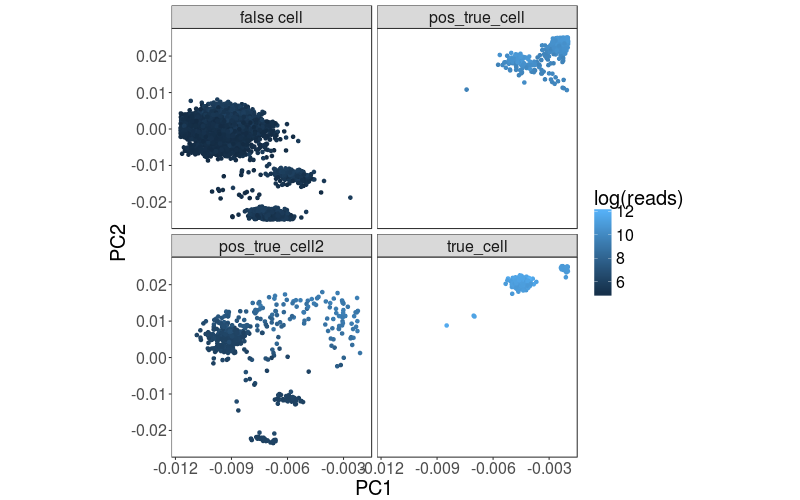

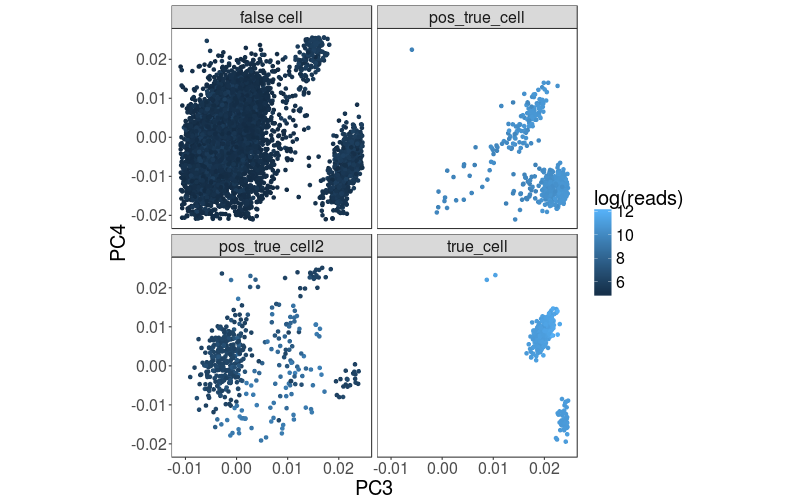

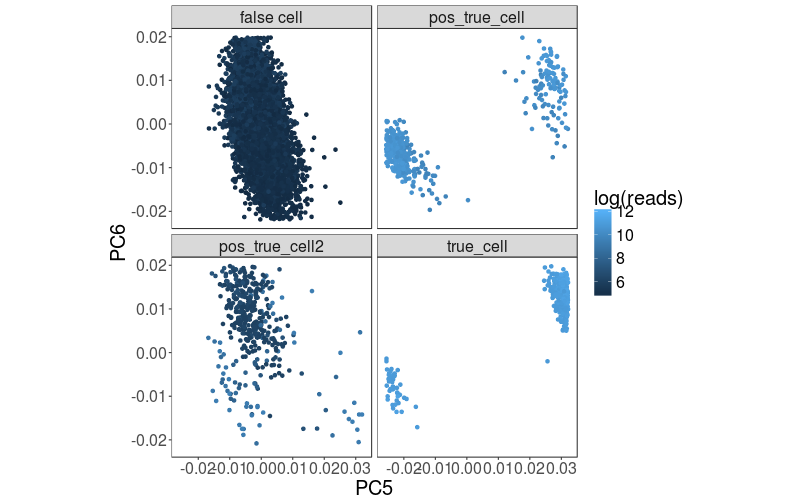

In [59]:
%%R -w 800 -h 500
printPCs(projections, colour_by="log(reads)", facet_by="cell_type")

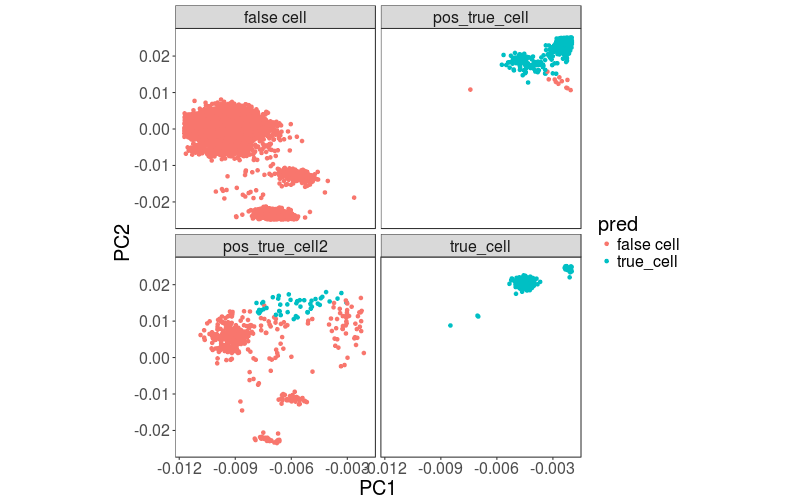

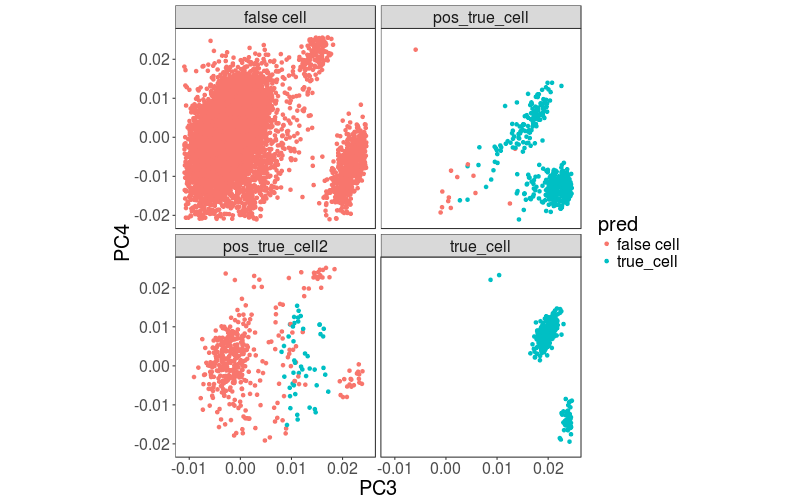

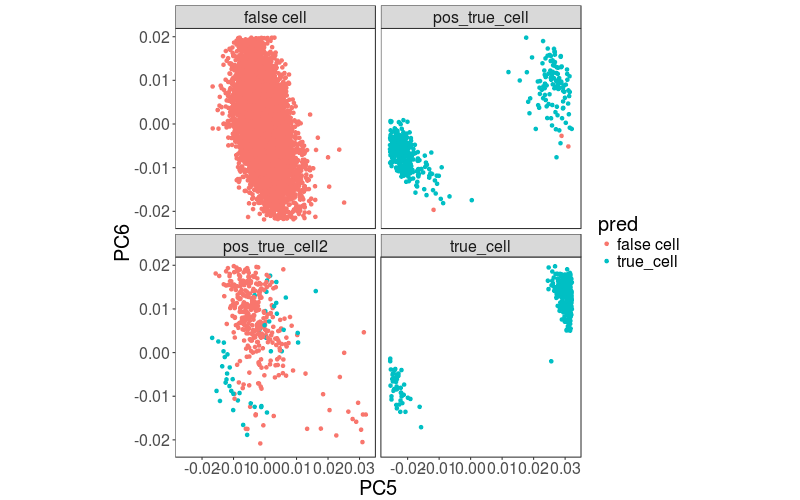

In [60]:
%%R -w 800 -h 500
printPCs(projections, colour_by="pred", facet_by="cell_type")

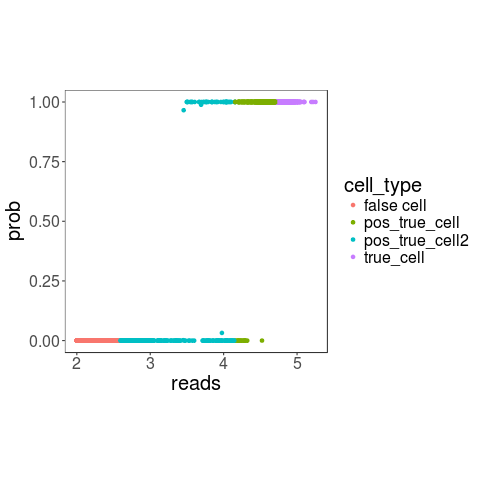

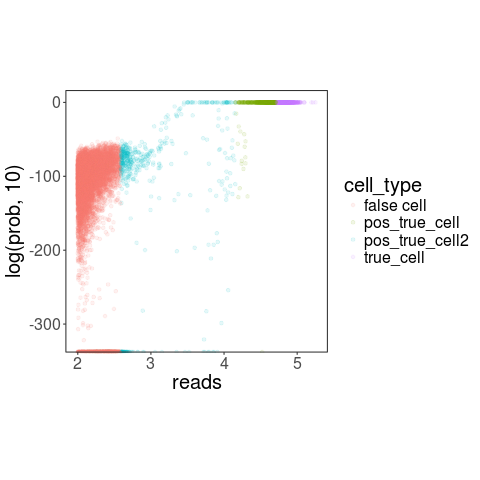

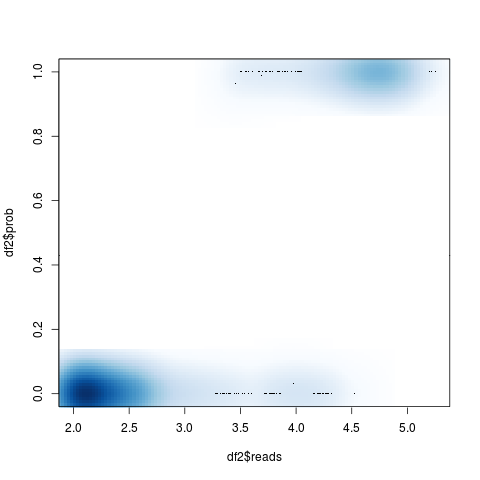

In [61]:
%%R
library(reshape2)
df2 = df
df2$reads = log(df2$reads,10)

p <- ggplot(df2, aes(reads, prob, colour=cell_type)) +
geom_point() + my_theme
print(p)

p <- ggplot(df2, aes(reads, log(prob,10), colour=cell_type)) +
geom_point(alpha=0.1) + my_theme
print(p)

smoothScatter(df2$reads, df2$prob)

How do the cells classified as true or false compare with respect to the metrics used to classify them, and the other metrics not used but expected to be higher for true cells, e.g the number of genes expressed, mean gene expression etc.

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Using cell_type, error, species, pred as id variables

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: notch went outside hinges. Try setting notch=FALSE.

  warnings.warn(x, RRuntimeWarning)


      cell_type error   species       pred variable    value
1 pos_true_cell FALSE        hg  true_cell    reads 4.390723
2    false cell  TRUE        mm false cell    reads 2.352183
3    false cell FALSE        hg false cell    reads 2.029384
4    false cell FALSE        hg false cell    reads 2.482874
5    false cell FALSE ambiguous false cell    reads 2.103804
6    false cell FALSE ambiguous false cell    reads 2.130334


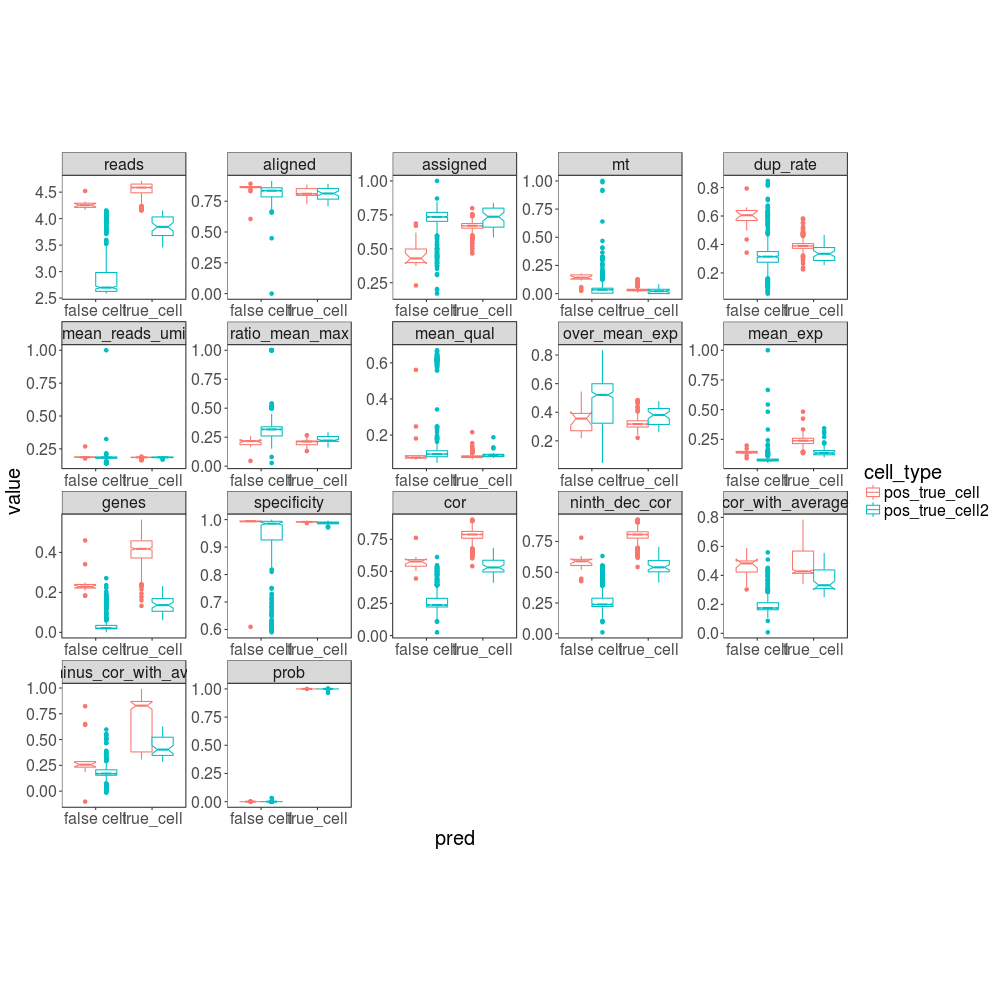

In [62]:
%%R -w 1000 -h 1000
df2 <- df2[df2$mean_reads_umi < 3,]
m_df <- melt(df2)
print(head(m_df))
p <- ggplot(m_df[m_df$cell_type %in% c("pos_true_cell", "pos_true_cell2"),],
                 aes(pred, value, colour=cell_type)) +
geom_boxplot(notch=T) + my_theme + facet_wrap(~variable, scales="free")
print(p)

Let's replot the PCA, leaving out the definitively false cells so we can see how the cells classified as true compare to those classified as false.

In [63]:
exp_arrays = {}
all_true_cells = true_cells.tolist()
all_true_cells.extend(pos_true_cells.tolist())
all_true_cells.extend(pos_true_cells2.tolist())
for cell in all_true_cells:
    exp_array = []
    for gene in all_genes:
        if gene in cell_umi_counts[cell]:
            exp_array.append(len(cell_umi_counts[cell][gene]))
        else:
            exp_array.append(0)

    exp_arrays[cell] = exp_array
    
exp_df = pd.DataFrame.from_records(exp_arrays, index=all_genes)

In [64]:
for cell in all_true_cells:
    exp_array = []
    for gene in all_genes:
        if len(cell_umi_counts[cell][gene]) == 0:
            del cell_umi_counts[cell][gene]

In [65]:
exp_df = pd.DataFrame.from_records(exp_arrays, index=all_genes)
exp_df = exp_df.div(exp_df.sum(axis=0), axis=1)
print(exp_df.shape)
exp_df['mean_exp'] = exp_df.mean(axis=1)
exp_df.sort_values("mean_exp", inplace=True, ascending=False)
exp_df.drop("mean_exp", axis=1)
exp_df = exp_df.ix[0:1000,]
print(exp_df.shape)

(28368, 1500)
(1000, 1501)


In [71]:
%%R -i exp_df
pred_true_cells = rownames(df[df$pred == "true_cell",])

#pca <- prcomp(log(exp_df[,colnames(exp_df) %in% pred_true_cells]+1), scale=T)
pca <- prcomp(exp_df, scale=T)


 [1] 0.426711551 0.288562475 0.042660837 0.019409950 0.008888377 0.005750146
 [7] 0.004198420 0.003336767 0.003053174 0.002813265


In [76]:
%%R -w 700 -h 700

#print(head(projections))

plotAnnotatedPCA <- function(pca, df, x=1, y=2, colour="reads"){
    projections <- pca$rotation[,1:20]
    projections <- merge(projections, df, by="row.names")
    var_explained <- 100*pca$sdev^2/(sum(pca$sdev^2))
    p <- ggplot(projections, aes_string(sprintf("PC%i", x), sprintf("PC%i", y), colour=colour)) +
    geom_point() + my_theme +
    xlab(sprintf("PC%i (%.2f %%)", x, var_explained[x])) +
    ylab(sprintf("PC%i (%.2f %%)", y, var_explained[y]))
    
    return(p)

}

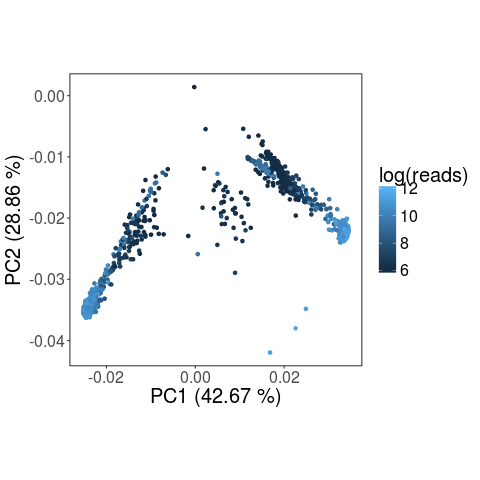

In [86]:
%%R

p <- plotAnnotatedPCA(pca, df, colour="log(reads)")
print(p)


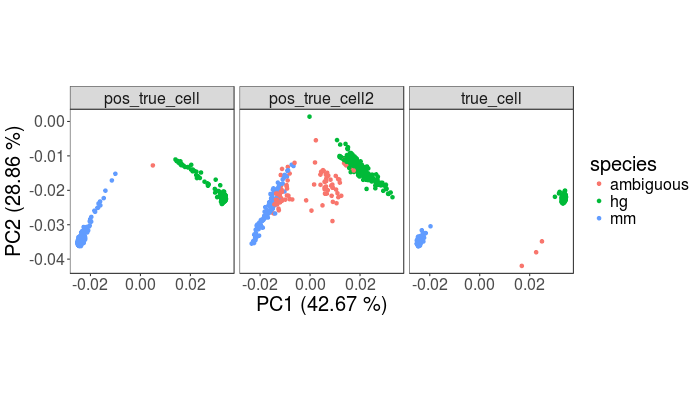

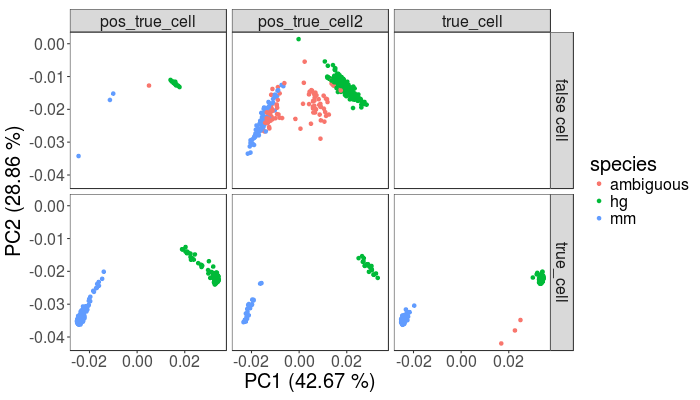

In [83]:
%%R -w 700 -h 400
p2 <- plotAnnotatedPCA(pca, df, colour="species") + facet_grid(.~cell_type)
print(p2)

p3 <- plotAnnotatedPCA(pca, df, colour="species") + facet_grid(pred~cell_type)
print(p3)


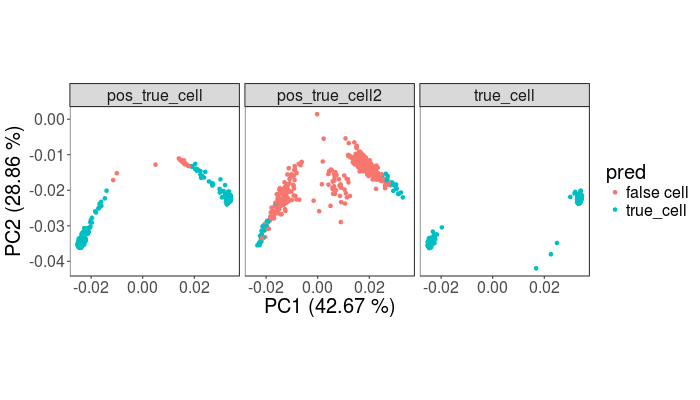

In [81]:
%%R -w 700 -h 400
p3 <- plotAnnotatedPCA(pca, df, colour="pred") + facet_grid(.~cell_type)
print(p3)

